# Topological regularization of cell cycle embedding

In this notebook, we show how a topological loss can be combined with a linear embedding procedure, as to regularize the embedding and better reflect the topological---in this case circular---prior. 

## Setup

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import pandas as pd 
import numpy as np
import pickle

# Loading R objects into python
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Pytorch compatible topology layer and losses
import torch
from topologylayer.nn import AlphaLayer

# Ordinary and topologically regularized PCA embedding
from Code.losses import get_topological_loss, pca_loss
from Code.training import compute_embedding
import Data.datasets as datasets
import Code.visualization as viz


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Quantitative evaluation
from sklearn.svm import SVC
from Code.evaluation import evaluate_embeddings

# Representative cycle analysis with alpha-filtrations
import networkx as nx
#import diode
import dionysus

# Tracking computation times
import time

#import wandb
#wandb.init(mode="disabled")

%matplotlib inline

sns.set_theme(context="paper", style="ticks",
              rc={"axes.spines.right": False,
                  "axes.spines.top": False,},
              font_scale=3,
              )
output_path = "Output/CellCycle/"
if not os.path.exists(output_path):
    os.mkdir(output_path)

/home/eheiter/Projects/topoembedding/topo_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-10-20 16:25:13.540788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 16:25:13.681617: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 16:25:13.681631: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your 

## Parameters

In [2]:
method_name = "ManoptPCA"
topo_weight = 0.01
random_state = 42

loss_config = {"one_circle": {"sampling": True,
                              "sampling_frac": 0.25,
                              "sampling_rep": 10}}
final_loss_config = {"one_circle": {"sampling": False}}

method_config = {
    "emb_loss": True,
}

training_config = {
    "max_iterations": 1000,
    "line_search": "custom",
    "initial_step_size": 0.01,
    "smooth_len1": 100,
    "smooth_len2": 50,
    "loss_tol": 1e-4
}

data, labels = datasets.get_cell_cycle_dataset()

## Ordinary PCA Embedding


Init PCA loss 6.7047, topo loss -11.7582
Running custom non adaptive update.
Optimizing...
Terminated - max iterations reached after 0.00 seconds.

Embedding time  0h  0m 0.6422s

Topological (using final loss): -13.535171508789062
epoch                          1
emb_loss                6.704727
topo_loss             -11.786142
weighted_topo_loss          -0.0
total_loss             -5.081415
weighted_total_loss     6.704727
gradient_norm           0.000082
Name: 0, dtype: object


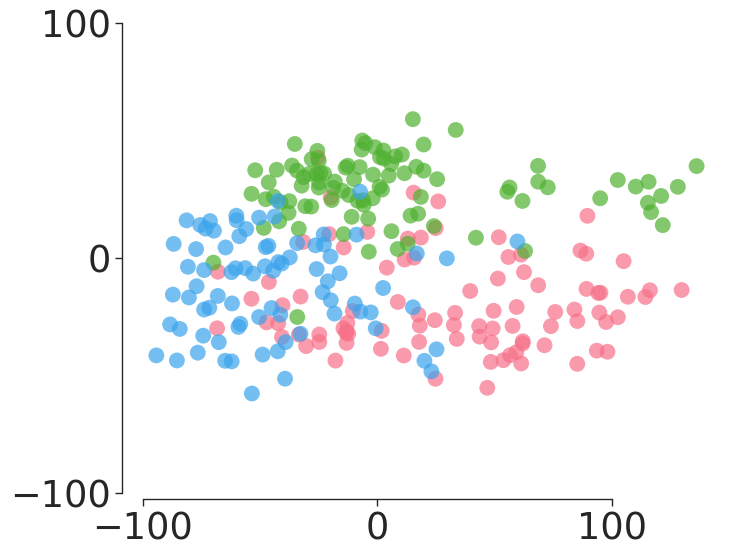

In [3]:
pca_training_config = training_config.copy()
pca_training_config["max_iterations"] = 0
Y_pca, results_dict = compute_embedding(data,
                                  method_name=method_name,
                                  method_config=method_config,
                                  loss_config=loss_config,
                                  topo_weight=0,
                                  training_config=pca_training_config,
                                  final_loss_config=final_loss_config,
                                  random_state=random_state,
                                  verbosity=1
                                  )
W_pca = results_dict["span_matrix"]
p = viz.plot_paper(Y_pca, colors=labels)
plt.savefig(os.path.join(output_path, "CellCirclePCA.png"), bbox_inches='tight', dpi=200)

## Apply topological regularization to the embedding

We now show how we can bias a linear embedding using a loss function that captures our topological prior.

The model we will use for this learns a linear projection $W$, which is optimized for the following three losses:
- the reconstruction loss between our data and its $X$ low-rank approximation $XWW^T$;
- a loss function encouraging orthonormality of $W$;
- a loss function that captures our topological prior.

As a topological loss, we will use the persistence of the most prominent cycle in our embedding. It is important to multiply this by a factor $\lambda_{\mathrm{top}} <0$, since we want this persistence to be high. To obtain this loss, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.


Init PCA loss 6.7047, topo loss -11.7582
Running custom non adaptive update.
Optimizing...
Stopping optimization because (obj_smooth) 0.00009 < 0.00010 (ftol)
Terminated - min grad norm reached after 507 iterations, 259.12 seconds.

Embedding time  0h  4m 19.9837s

Topological (using final loss): -44.40443420410156
epoch                        507
emb_loss                6.784643
topo_loss             -46.971741
weighted_topo_loss     -0.469717
total_loss            -40.187098
weighted_total_loss     6.314925
gradient_norm                0.0
Name: 506, dtype: object


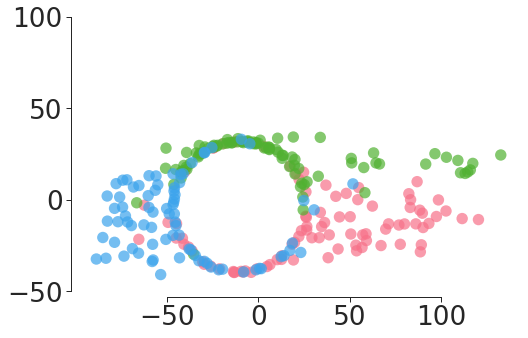

In [4]:
Y_reg, results_dict = compute_embedding(data,
                                  method_name=method_name,
                                  method_config=method_config,
                                  loss_config=loss_config,
                                  topo_weight=topo_weight,
                                  training_config=training_config,
                                  final_loss_config=final_loss_config,
                                  random_state=random_state,
                                  verbosity=1
                                  )
W_reg = results_dict["span_matrix"]
p = viz.plot_paper(Y_reg, colors=labels)
plt.savefig(os.path.join(output_path, "CellCirclePCAopt.png"), dpi=200, bbox_inches='tight')

We observe that we can regularize our linear embedding through the topological prior, obtaining a much more prominent cycle, while maintaining a nearly identical reconstruction error.

## Compare with ordinary topological optimization

For comparison, we also conduct the same topological optimization procedure directly on the initialized embedding.


Init PCA loss 0.0000, topo loss -11.7582
Running custom non adaptive update.
Optimizing...
Stopping optimization because (obj_smooth) 0.00007 < 0.00010 (ftol)
Terminated - min grad norm reached after 434 iterations, 175.21 seconds.

Embedding time  0h  2m 55.8401s

Topological (using final loss): -54.8961067199707
epoch                        434
emb_loss                     0.0
topo_loss             -53.684288
weighted_topo_loss     -0.536843
total_loss            -53.684288
weighted_total_loss    -0.536843
gradient_norm                0.0
Name: 433, dtype: object


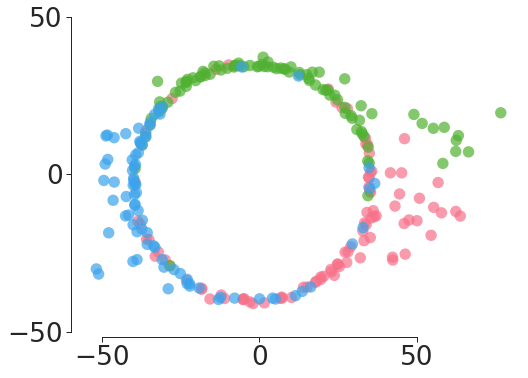

In [6]:
Y_opt, results_dict = compute_embedding(data,
                                  method_name=method_name,
                                  method_config={'emb_loss': False},
                                  loss_config=loss_config,
                                  topo_weight=topo_weight,
                                  training_config=training_config,
                                  final_loss_config=final_loss_config,
                                  random_state=random_state,
                                  verbosity=1
                                  )
W_opt = results_dict["span_matrix"]
p = viz.plot_paper(Y_opt, colors=labels)
plt.savefig(os.path.join(output_path, "CellCircleTop.png"), dpi=200, bbox_inches='tight')

We observe that the results are highly similar.

## Quantitative evaluation

First, we evaluate the circular loss without sampling for all embeddings.

In [7]:
circle_loss = get_topological_loss("one_circle", **{"one_circle": {"sampling": False}}["one_circle"])

print(f"Y_PCA: {circle_loss(torch.tensor(Y_pca).type(torch.float))}")
print(f"Y_reg: {circle_loss(torch.tensor(Y_reg).type(torch.float))}")
print(f"Y_opt: {circle_loss(torch.tensor(Y_opt).type(torch.float))}")

Y_PCA: -10.177163124084473
Y_reg: -63.52378845214844
Y_opt: -68.34359741210938


Finally, we compare if the topologically regularized embedding improves on the ordinary PCA embedding for predicting data point labels.

In [8]:
# Machine learning model to be used for label prediction
Ys = {"pca": Y_pca, "top. opt.": Y_opt, "top. reg.": Y_reg}
model = SVC()
scoring = "accuracy"

# Hyperparameters for quantitative evaluation
ntimes = 100
test_frac = 0.1
params = {"C":[0.01, 0.1, 1, 10, 100]}

# Obtain performances over multiple train-test splits
performances = evaluate_embeddings(Ys, labels, model, scoring, params=params, stratify=labels, 
                                   ntimes=ntimes, test_frac=test_frac, random_state=42)

# View resulting performances
pd.concat([pd.DataFrame({"mean":performances.mean(axis=0)}),
           pd.DataFrame({"std":performances.std(axis=0)})], axis=1)\
            .style.highlight_max(subset="mean", color="lightgreen", axis=0)

,mean,std
pca,0.787778,0.070402
top. opt.,0.785926,0.072673
top. reg.,0.781481,0.073416


## Pseudotime analysis with persistent homology
Persistent homology can now be used to study the topological information from the embedded data within an exploratory data analysis setting. In this case, it allows one to conveniently obtain and study a representation. We will do this for both our ordinary PCA embedding, as well as our topologically regularized embedding.

To obtain the representative cycle we need to install [DioDe](https://github.com/mrzv/diode) (e.g. by 'pip install diode')

### Pseudotimes for ordinary PCA embedding
We first obtain a representative cycle from the alpha-filtration as follows.

In [4]:
import diode

In [5]:
# Compute persistent homology and obtain a representative cocycle
simplices = diode.fill_alpha_shapes(Y_pca)
filtration = dionysus.Filtration(simplices)
PH = dionysus.homology_persistence(filtration)
dgms = dionysus.init_diagrams(PH, filtration)
pt = max(dgms[1], key=lambda pt: pt.death - pt.birth)

# Obtain a representation of the most prominent cycle in the embedding
cycle_raw = PH[PH.pair(pt.data)]
cycle = [s for s in cycle_raw]
cycle = np.array([list(filtration[s.index]) for s in cycle_raw])

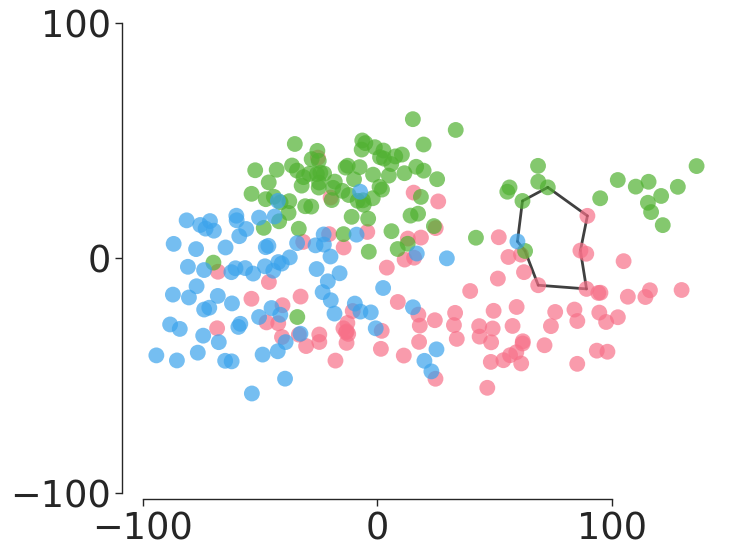

In [6]:
# View the representation of the most prominent cycle in the topologically regularized embedding
fig, ax = plt.subplots(figsize=(8, 8))
for e in cycle:
    plt.plot([Y_pca[e[0], 0], Y_pca[e[1], 0]], [Y_pca[e[0], 1], Y_pca[e[1], 1]], 
             linewidth=2, color="black", alpha=0.75, zorder=0)
p = viz.plot_paper(Y_pca, colors=labels, ax=ax)
#sns.scatterplot(x=Y_pca[:,0], y=Y_pca[:,1], s=50, hue=labels, palette="husl", zorder=1)
plt.savefig(os.path.join(output_path, "CellCircle_diode.png"), dpi=200, bbox_inches='tight')
plt.show()

We can now project the entire set of embedded data points on the representative cycle as follows.

In [12]:
# Projection of topologically regularized data embedding on representative cycle
P = np.zeros(Y_pca.shape) # data projection
startpoint = [0 for p in Y_pca] # edge startpoint for each projected point
endpoint = [0 for p in Y_pca] # edge endpoint for each projected point
mu = [0 for p in Y_pca] # normalized distance of projected point to startpoint
for idx1 in range(Y_pca.shape[0]):
    dist = np.inf
    
    if idx1 in np.unique(cycle.flatten()):
        # special case where we don't have to consider all edges
        P[idx1, :] = Y_pca[idx1]
        startpoint[idx1] = idx1
        endpoint[idx1] = idx1
        mu[idx1] = 1
        dist = 0
    else:
        for idx2 in range(cycle.shape[0]):
            s = Y_pca[cycle[idx2, 0],:]
            e = Y_pca[cycle[idx2, 1],:]
            this_mu = max(0, min(1, np.sum((Y_pca[idx1,:] - s) * (e - s)) / np.sum((e-s)**2)))
            projection = s + this_mu * (e - s)
            this_dist = np.linalg.norm(Y_pca[idx1,:] - projection)
            
            if this_dist < dist:
                P[idx1,:] = projection
                startpoint[idx1] = cycle[idx2, 0]
                endpoint[idx1] = cycle[idx2, 1]
                mu[idx1] = this_mu
                dist = this_dist

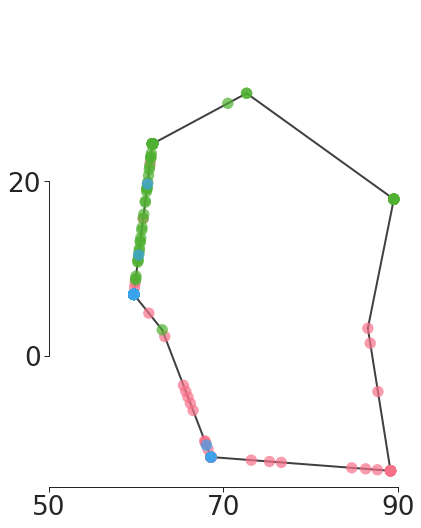

In [13]:
# Random permutation to better see the overlap in the projection
np.random.seed(49)
random_order = np.random.permutation(Y_pca.shape[0])
circle_df = pd.DataFrame({'x': P[:, 0], 'y': P[:, 1], 'label': labels})
p_random = np.array(circle_df.iloc[random_order][["x", "y"]])
p_random_labels = list(circle_df.iloc[random_order]["label"])


# View the projection of the embedded data points on the representative cycle 
fig, ax = plt.subplots(figsize=(8, 8))

for e in cycle:
    plt.plot([Y_pca[e[0], 0], Y_pca[e[1], 0]], [Y_pca[e[0], 1], Y_pca[e[1], 1]], 
             linewidth=2, color="black", alpha=0.75, zorder=0)
    
p = viz.plot_paper(P, colors=labels, ax=ax)

p.get_axes()[0].set_yticks([0, 20])
p.get_axes()[0].set_ylim([-15, 40])
p.get_axes()[0].set_xticks([50, 70, 90])
sns.despine(offset=0, trim=True)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "CellCircle_diodeProjected.png"), dpi=200, bbox_inches='tight')
plt.show()

Finally, we use this projection to obtain circular coordinates for the entire data.

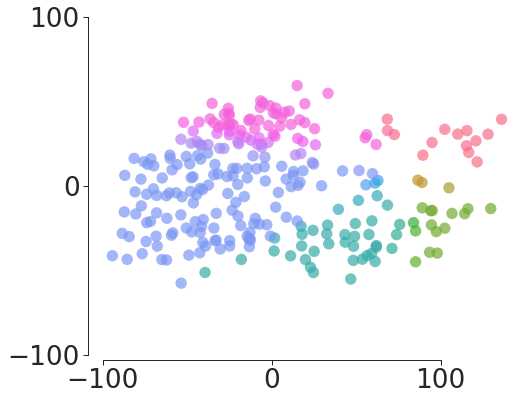

In [14]:
# First obtain coordinates for the points on the representative cycle
G = nx.Graph()
G.add_edges_from(cycle)
cycle_nodes = np.unique(cycle)
start_node = cycle_nodes[np.argmax(Y_pca[cycle_nodes,0])]
end_node = list(G.neighbors(start_node))[np.argmax(Y_pca[list(G.neighbors(start_node)),1])]
G.remove_edge(start_node, end_node)
path = nx.shortest_path(G, start_node, end_node)
C = np.zeros([Y_pca.shape[0]])
for idx in range(1, len(path)):
    C[path[idx]] = np.linalg.norm(Y_pca[path[idx],:] - Y_pca[path[idx - 1],:]) + C[path[idx - 1]]

# Obtain a circular coordinate for each data point
for idx in range(Y_pca.shape[0]):
    if (startpoint[idx] == start_node) and (endpoint[idx] == end_node):
        print("special case")
        C[idx] = mu[idx] * np.linalg.norm(Y_reg[end_node,:] - Y_reg[start_node,:]) + C[end_node]
    else:
        C[idx] = (1 - mu[idx]) * C[startpoint[idx]] + mu[idx] * C[endpoint[idx]]
C = C.astype("float") * 2 * np.pi / (max(C) + np.linalg.norm(Y_pca[path[len(path) - 1],:] - Y_pca[path[0],:]))

# View the points in the topologically regularized embedding using hue to show the circular coordinates
p = viz.plot_paper(Y_pca, colors=C)
plt.savefig(os.path.join(output_path, "CellCircle_diodeCoordinates.png"))
plt.show()

### Pseudotimes for topologically regularized PCA embedding
We first obtain a representative cycle from the alpha-filtration as follows.

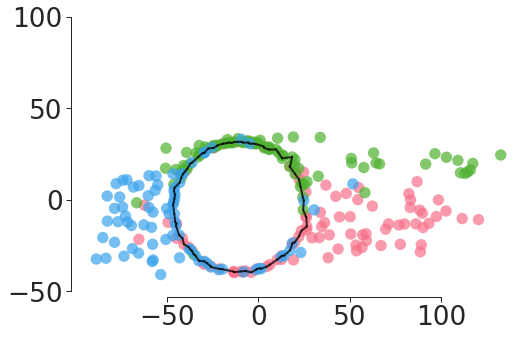

In [15]:
# Compute persistent homology and obtain a representative cocycle
simplices = diode.fill_alpha_shapes(Y_reg)
filtration = dionysus.Filtration(simplices)
PH = dionysus.homology_persistence(filtration)
dgms = dionysus.init_diagrams(PH, filtration)
pt = max(dgms[1], key=lambda pt: pt.death - pt.birth)

# Obtain a representation of the most prominent cycle in the embedding
cycle_raw = PH[PH.pair(pt.data)]
cycle = [s for s in cycle_raw]
cycle = np.array([list(filtration[s.index]) for s in cycle_raw])

# View the representation of the most prominent cycle in the topologically regularized embedding
fig, ax = plt.subplots(figsize=(8, 8))
for e in cycle:
    plt.plot([Y_reg[e[0], 0], Y_reg[e[1], 0]], [Y_reg[e[0], 1], Y_reg[e[1], 1]], 
             linewidth=2, color="black", alpha=0.75)
p = viz.plot_paper(Y_reg, colors=labels, ax=ax)
plt.savefig(os.path.join(output_path, "CellCircle_diodeTimeCircle.png"))
plt.show()

We can now project the entire set of embedded data points on the representative cycle as follows.

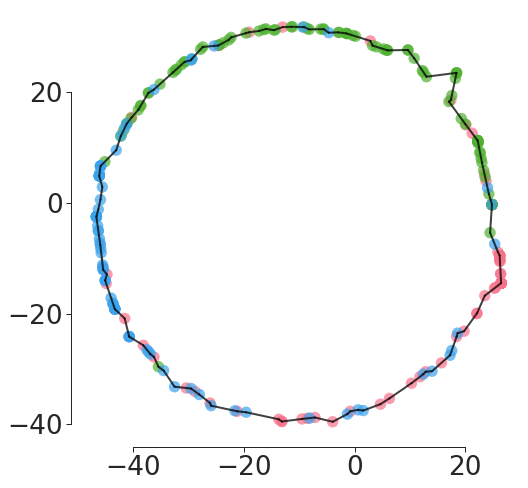

In [16]:
# Random permutation to better see the overlap in the projection
np.random.seed(42)
random_order = np.random.permutation(Y_reg.shape[0])

# Projection of topologically regularized data embedding on representative cycle
P = np.zeros(Y_reg.shape) # data projection
startpoint = [0 for p in Y_reg] # edge startpoint for each projected point
endpoint = [0 for p in Y_reg] # edge endpoint for each projected point
mu = [0 for p in Y_reg] # normalized distance of projected point to startpoint
for idx1 in range(Y_reg.shape[0]):
    dist = np.inf
    for idx2 in range(cycle.shape[0]):
            s = Y_reg[cycle[idx2, 0],:]
            e = Y_reg[cycle[idx2, 1],:]
            this_mu = max(0, min(1, np.sum((Y_reg[idx1,:] - s) * (e - s)) / np.sum((e-s)**2)))
            projection = s + this_mu * (e - s)
            this_dist = np.linalg.norm(Y_reg[idx1,:] - projection)

            if this_dist < dist:
                P[idx1,:] = projection
                startpoint[idx1] = cycle[idx2, 0]
                endpoint[idx1] = cycle[idx2, 1]
                mu[idx1] = this_mu
                dist = this_dist
            
# View the projection of the embedded data points on the representative cycle 
fig, ax = plt.subplots(figsize=(8, 8))

for e in cycle:
    plt.plot([Y_reg[e[0], 0], Y_reg[e[1], 0]], [Y_reg[e[0], 1], Y_reg[e[1], 1]], 
             linewidth=2, color="black", alpha=0.75)
p = viz.plot_paper(P, colors=labels, ax=ax)
plt.savefig(os.path.join(output_path, "CellCircle_diodeTimeProjection.png"), dpi=200, bbox_inches='tight')
plt.show()

We now use this projection to obtain circular coordinates for the entire data.

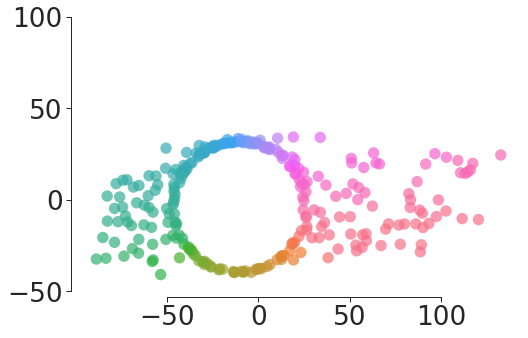

In [17]:
# First obtain coordinates for the points on the representative cycle
G = nx.Graph()
G.add_edges_from(cycle)
cycle_nodes = np.unique(cycle)
start_node = cycle_nodes[np.argmax(Y_reg[cycle_nodes,0])]
end_node = list(G.neighbors(start_node))[np.argmax(Y_reg[list(G.neighbors(start_node)),1])]
G.remove_edge(start_node, end_node)
path = nx.shortest_path(G, start_node, end_node)
C = np.zeros([Y_reg.shape[0]])
for idx in range(1, len(path)):
    C[path[idx]] = np.linalg.norm(Y_reg[path[idx],:] - Y_reg[path[idx - 1],:]) + C[path[idx - 1]]

    
# Obtain a circular coordinate for each data point
for idx in range(Y_reg.shape[0]):
    if (startpoint[idx] == start_node) and (endpoint[idx] == end_node):
        C[idx] = mu[idx] * np.linalg.norm(Y_reg[end_node,:] - Y_reg[start_node,:]) + C[end_node]
    else: 
        C[idx] = (1 - mu[idx]) * C[startpoint[idx]] + mu[idx] * C[endpoint[idx]]
C = C.astype("float") * 2 * np.pi / (max(C) + np.linalg.norm(Y_reg[path[len(path) - 1],:] - Y_reg[path[0],:]))
    
# View the points in the topologically regularized embedding using hue to show the circular coordinates
p = viz.plot_paper(Y_reg, colors=C)
plt.savefig(os.path.join(output_path, "CellCircle_diodeTimeCoordinates.png"), dpi=200, bbox_inches='tight')
plt.show()

## Varying hyperparameters in sampling loss

Finally, we explore how topological regularization reacts to different sampling fractions $f_{\mathcal{S}}$ and repeats $n_{\mathcal{S}}$. The different embeddings are obtained as follows only running for 100 epochs. 

In [19]:
#pickle.dump(sampling_df, open(os.path.join(output_path, "sampling.pkl"), 'wb'))

In [23]:
if os.path.isfile(os.path.join(output_path, "sampling.pkl")):
    sampling_df = pickle.load(open(os.path.join(output_path, "sampling.pkl"), 'rb'))
else:
    #sampling_df = pd.DataFrame(columns=["sampling_frac", "sampling_rep", "emb_loss", "max_iterations", "time", "emb", "topo_weight"])
    # Definine sampling fractions and repeats
    top_fracs = [0.1, 0.25, 0.5, 1]
    emb_losses = [True]
    topo_weight = 0.01
    max_iterations = 1000

    # Construct embedding for each sampling fraction and repeat combination
    for f in top_fracs:
        for l in emb_losses:
            n = int(1/f)
            loss_config = {"one_circle": {"sampling": True,
                                "sampling_frac": f,
                                "sampling_rep": n}}
            method_config = {
                                "emb_loss": l,
                                "max_iterations":max_iterations,
                                "line_search":"custom",
                                "initial_step_size":0.01,
                                "smooth_len1":100,
                                "smooth_len2":50,
                                "loss_tol":1e-4
                            }
            # Conduct embedding
            print("\033[1mConducting embedding for sampling fraction " + str(f) + 
                    " with " + str(n) + " repeats\033[0m")
            
            # Track total embedding time
            start_time = time.time() 
            emb, _ = compute_embedding(data,
                                       method_name=method_name,
                                       training_config=training_config,
                                       loss_config=loss_config,
                                       topo_weight=topo_weight,
                                       method_config=method_config)
            emb_time = time.time() - start_time
            print("\n")
            sampling_df = sampling_df.append({"sampling_frac": f,
                                            "sampling_rep": n,
                                            "emb_loss": l,
                                            "max_iterations": max_iterations,
                                            "emb": emb,
                                            "time": emb_time,
                                            "topo_weight": topo_weight}, ignore_index=True)
            #pickle.dump(sampling_df, open(os.path.join(output_path, "sampling.pkl"), 'wb'))

We visuallize all embeddings as follows.

/topoembedding/Code/visualization.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/topoembedding/Code/visualization.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/topoembedding/Code/visualization.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/topoembedding/Code/visualization.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/topoembedding/Code/visualization.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/topoembedding/Code/visualization.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so

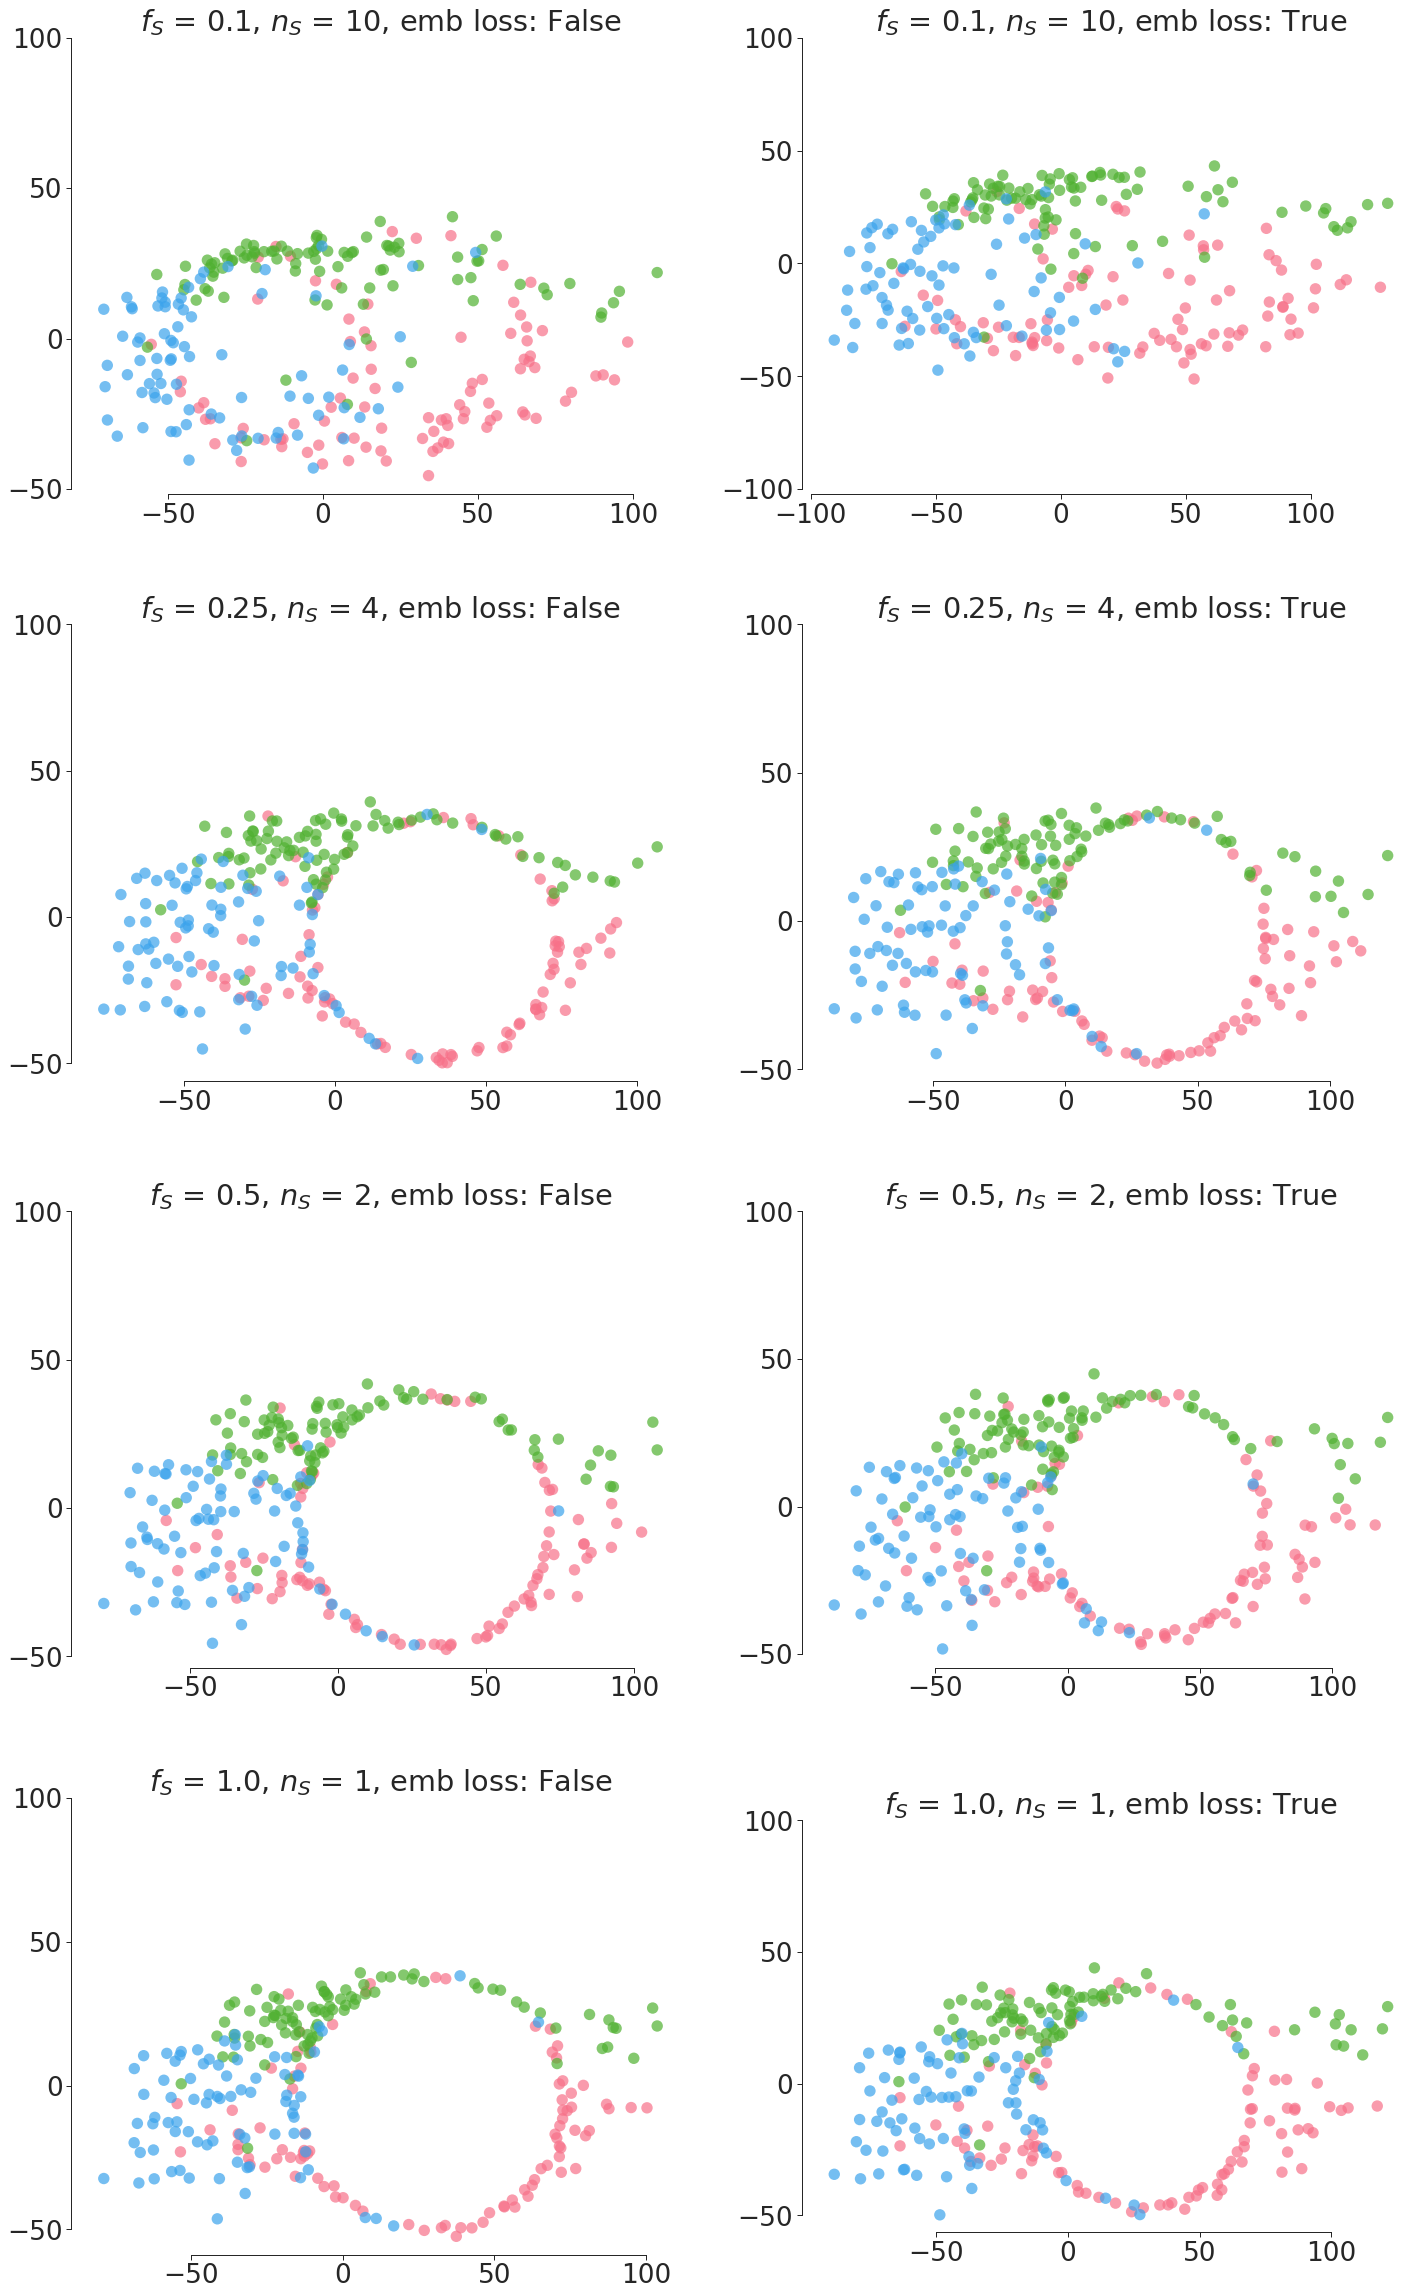

In [36]:
fig, ax = plt.subplots(len(sampling_df.sampling_frac.unique()),
                       len(sampling_df.emb_loss.unique()),
                       figsize=(len(sampling_df.emb_loss.unique()) * 10, len(sampling_df.sampling_frac.unique()) * 8),
                       gridspec_kw={"hspace": 0.3})
fig.subplots_adjust(0.05,0.02,0.98,0.98)

for idx1, f in enumerate(sampling_df.sampling_frac.unique()):
    for idx2, l in enumerate(sampling_df.emb_loss.unique()):       
        p = viz.plot_paper(sampling_df.loc[(sampling_df.sampling_frac == f) 
                                           & (sampling_df.emb_loss == l)
                                           & (sampling_df.topo_weight == topo_weight)]["emb"].item(),
                           colors=labels,
                           title="$f_S$ = {}, $n_S$ = {}, emb loss: {}".format(f, int(1/f), l),
                           ax=ax[idx1, idx2])


plt.savefig(os.path.join(output_path, "CellCircle_sampling_grid.png"))
plt.show()